**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Introducción a Keras LSTM para series de tiempo multivariadas

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Contenido

* [Introducción](#Introducción)
* [Importar las librería requeridas](#Importar-las-librería-requeridas)
* [El conjunto de datos weather](#El-conjunto-de-datos-weather)
* [Función para preparar datos univariados de entrenamiento ](#Función-para-preparar-datos-univariados-de-entrenamiento )
* [Parte 1: Pronóstico de una serie de tiempo univariada](#Parte-1:-Pronóstico-de-una-serie-de-tiempo-univariada)
* [Modelo línea base: Baseline](#Modelo-línea-base)
* [Breve revisión de cache, shuffle, batch y repeat](#Breve-revisión-de-cache,-shuffle,-batch-y-repeat)
* [Crea el modelo LSTM univariado](#Crea-el-modelo-LSTM-univariado)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones](#Predicciones)
* [Parte 2: Pronóstico de una serie de tiempo multivariada](#Parte-2:-Pronóstico-de-una-serie-de-tiempo-multivariada) 
* [Modelo de un Paso](#Modelo-de-un-paso)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones](#Predicciones)
* [Modelo Multipaso](#Modelo-Multipaso)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones](#Predicciones)
* [Los siguientes pasos](#Los-siguientes-pasos)

## Referencias

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
2. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)
3. [Tensoflow-Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

## Introducción


Este cuaderno es  una introducción a la predicción de series de tiempo utilizando redes neuronales recurrentes (RNN). Esto se cubre en dos partes: primero, pronosticará una serie de tiempo univariada, luego pronosticará una serie de tiempo multivariada.


## Importar las librería requeridas

In [5]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## El conjunto de datos weather 


Usaremos el conjunto de datos (dataset) [weather time series dataset recorded by the Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). Estan disponibles en [kaggle](https://www.kaggle.com/kusuri/jena-climate), en una versión preparada por Francois Chollet, la cual usaremos aquí.

Este dataset contiene 14 variables (features) diferentes tales como temperatura ambiente, presión atmosférica, y humedad. Estos datos fueron recolectados cada 10 minutos, comenzando en 2003. Por eficiencia, usaremos los datos recolectados entre 2009 y 2016. Estos datos fueron preparados por François Chollet para su libro Deep Learning with Python. En total son 420551 registros de datos.

In [6]:
# download teh data and store it in your system
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
# after download the file is in this path
csv_path, _ = os.path.splitext(zip_path) # /home/alvaro/.keras/datasets/jena_climate_2009_2016.csv'


In [3]:
csv_path

'/home/alvaro/.keras/datasets/jena_climate_2009_2016.csv'

In [12]:
df = pd.read_csv(csv_path)

### Una primera mirada a los datos 

In [13]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82



Como puede verse arriba, se registra una observación cada 10 minutos. Esto significa que, durante una hora, se tendrán 6 observaciones. Del mismo modo, en un  día se tienen 144 (6x24) observaciones. En total son 420551 observaciones.

Dado un tiempo específico, digamos que desea predecir la temperatura 6 horas en el futuro. Para hacer esta predicción, se elige usar 5 días de observaciones. Por lo tanto, crearía una ventana que contiene las últimas 720 (5x144) observaciones para entrenar el modelo. Son posibles muchas de estas configuraciones, lo que hace que este conjunto de datos sea bueno para experimentar.

La siguiente función devuelve las ventanas de tiempo descritas anteriormente para entrenar el modelo. El parámetro *history_size* es el tamaño de la ventana de información pasada. El *target_size* es qué tan lejos en el futuro necesita el modelo aprender a predecir; *target_size* es la etiqueta que debe predecirse.

## Función para preparar datos univariados de entrenamiento 

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

En las partes  siguientes, las primeras 300,000 filas de datos serán el conjunto de datos de entrenamiento, y el resto será el conjunto de datos de validación (120551). Esto equivale a unos 2100 días de datos de entrenamiento.


In [8]:
TRAIN_SPLIT = 300000

Se coloca una semilla para gerantizar reproductibidad

In [9]:
tf.random.set_seed(13)

## Parte 1: Pronóstico de una serie de tiempo univariada


Primero, se entrenará un modelo usando solo una característica (temperatura), y lo luego se usará para hacer predicciones de ese valor en el futuro.

Primero extraigamos solamente la temperatura del conjunto de datos.

In [15]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.columns = ['T (degC)']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Observemos como lucen los datos a lo largo del tiempo.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d68313b50>],
      dtype=object)

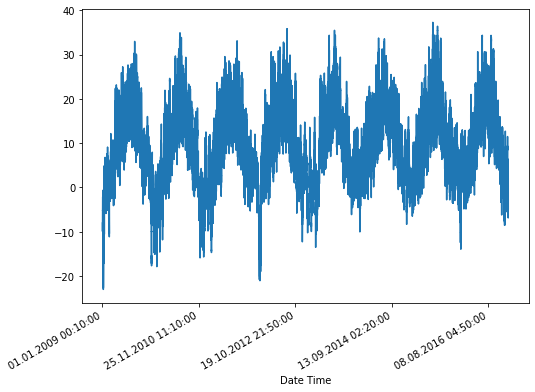

In [16]:
uni_data.plot(subplots=True)

In [17]:
uni_data = uni_data.values # transform to numpy array

### Estandarización (Rescalado) de los datos

Es importante escalar las características antes de entrenar una red neuronal. La estandarización es una forma común de hacer esta escala restando la media y dividiendo por la desviación estándar de cada característica. También podría usar un método *tf.keras.utils.normalize* que reescala los valores para tener para tener media 0 y varianza 1.

In [18]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


Ahora creamos los datos para el modelo univariado. Para la parte 1, el modelo recibirá las últimas 20 observaciones de temperatura registradas, y necesita aprender a predecir la temperatura en el siguiente paso.

In [14]:
# def univariate_data(dataset, start_index, end_index, history_size, target_size):

In [19]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Esto es lo que la función *univariate_data* retorna.

In [22]:
print ('Ventana  de la historia pasada')
print (x_train_uni[1])
print ('\n Temperature objetivo (target) para predecir')
print (y_train_uni[1])

Ventana  de la historia pasada
[[-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Temperature objetivo (target) para predecir
-2.094922084553636


Ahora que se han creado los datos, echemos un vistazo a un solo ejemplo. La información dada a la red se da en azul y debe predecir el valor en la cruz roja.

In [20]:
def create_time_steps(length):
  return list(range(-length, 0))

In [21]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

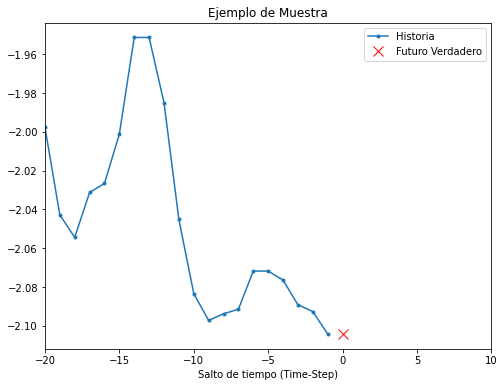

In [22]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Ejemplo de Muestra')
plt.show()

## Modelo línea base


Antes de proceder a entrenar un modelo, primero establezcamos una línea base simple. Dado un punto de entrada, el método de línea de base analiza todo el historial y predice que el siguiente punto será el promedio de las últimas 20 observaciones.

In [20]:
def baseline(history):
  return np.mean(history)

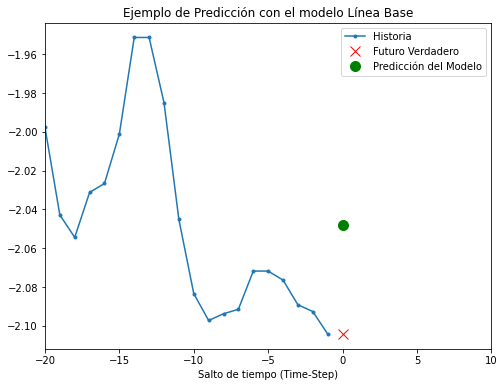

In [21]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Ejemplo de Predicción con el modelo Línea Base')
plt.show()

# Redes  Neuronales Recurrentes


Una red neuronal recurrente (RNR) es un tipo de red neuronal muy adecuada para datos de series temporales. Los RNR procesan una serie temporal paso a paso, manteniendo un estado interno que resume la información que han visto hasta ahora.  En este cuaderno, se utilizará una capa RNR especializada llamada Memoria a largo plazo (LSTM). Para más detalles, lea el cuaderno [Introducción a redes LSTM.](Intro_LSTM.ipynb)

Ahora usemos *tf.data.Dataset* para mezclar, agrupar y almacenar en caché el conjunto de datos.

In [36]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

## Breve revisión de cache, shuffle, batch y repeat

### ¿Cómo trabaja dataset.shuffle()?

### ¿Cómo trabaja dataset.repeat() ?

### ¿ Qué produce dataset.batch?

<figure>
<center>
<img src="../Imagenes/time_series.png" width="400" height="200" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Diagrama Representando los datos luego de organizarlos por lotes (batching)"</p>
</figcaption>
</figure>

### ¿ Qué es el caché?

Los datos almacenados en caché son archivos, scripts, imágenes y otros elementos multimedia almacenados en su dispositivo después de abrir una aplicación o visitar un sitio web por primera vez. Estos datos se utilizan para cargar rápidamente información sobre la aplicación o el sitio web cada vez que se revisa. 

La memoria caché tiene una latencia extremadamente baja, lo que significa que se puede acceder muy rápidamente. La otra cara de la baja latencia significa que no se puede almacenar mucha memoria. Esta es la razón por la cual los archivos de pequeño tamaño  se almacenan en la memoria caché. 

Como cualquier red implementada en *tf.keras*  la capa de entrada requiere require el tamaño de entrada de los datos.


## Crea el modelo uinivariado

In [37]:
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.Dense(1)
#])

simple_lstm_model = tf.keras.models.Sequential()
simple_lstm_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]))
simple_lstm_model.add(tf.keras.layers.Dense(1))

In [25]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


## Compila

In [38]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

Hagamos la predicción de un muestra para chequear la salida del modelo.

In [39]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x))

[[0.09426321]
 [0.09406173]
 [0.09384207]
 [0.09361085]
 [0.09340203]
 [0.09318742]
 [0.0931512 ]
 [0.09312333]
 [0.0929764 ]
 [0.09277759]
 [0.09261883]
 [0.09255859]
 [0.09247175]
 [0.09225555]
 [0.09197575]
 [0.09168132]
 [0.09135348]
 [0.09104502]
 [0.09079006]
 [0.09049822]
 [0.09021151]
 [0.09010814]
 [0.0899355 ]
 [0.08971277]
 [0.08990423]
 [0.08996822]
 [0.08993262]
 [0.08990892]
 [0.08992364]
 [0.08988826]
 [0.08979523]
 [0.08980487]
 [0.08984829]
 [0.08990407]
 [0.09003419]
 [0.09017841]
 [0.090256  ]
 [0.09043316]
 [0.09094715]
 [0.09155883]
 [0.09229261]
 [0.09274109]
 [0.09305485]
 [0.09330931]
 [0.09386633]
 [0.09445558]
 [0.09489156]
 [0.09529744]
 [0.09555635]
 [0.09555367]
 [0.09547371]
 [0.09552869]
 [0.09565598]
 [0.09605214]
 [0.09665722]
 [0.09711088]
 [0.09746988]
 [0.09778761]
 [0.09808844]
 [0.09838728]
 [0.09860709]
 [0.09872137]
 [0.09886372]
 [0.09889001]
 [0.09894174]
 [0.09900074]
 [0.0991224 ]
 [0.0992992 ]
 [0.0995585 ]
 [0.09978216]
 [0.0999187 ]
 [0.10

## Entrena

Vamos a entrenar el modelo ahora. Debido al gran tamaño del conjunto de datos, en aras de ahorrar tiempo, cada época (epoch) solo se ejecutará durante 200 pasos, en lugar de los datos de entrenamiento completos como se hace normalmente.


In [40]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 11s 53ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 6s 29ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 6s 29ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 6s 28ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0263 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 10/10
200/200 [==========================

## Evaluación

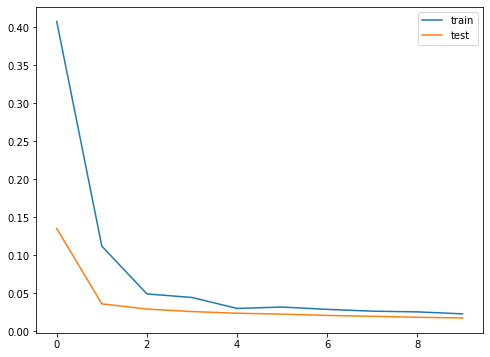

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Predicción

Ahora que se ha entrenado su LSTM simple, intentemos hacer algunas predicciones.

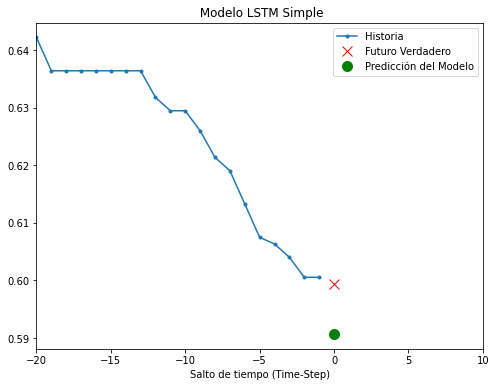

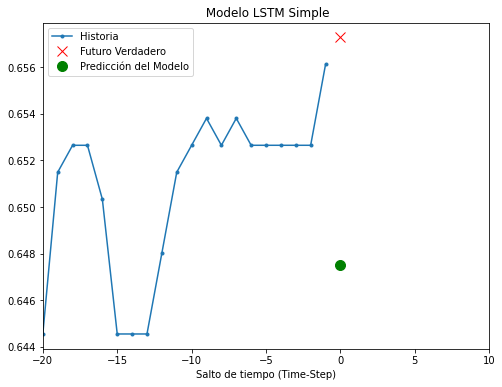

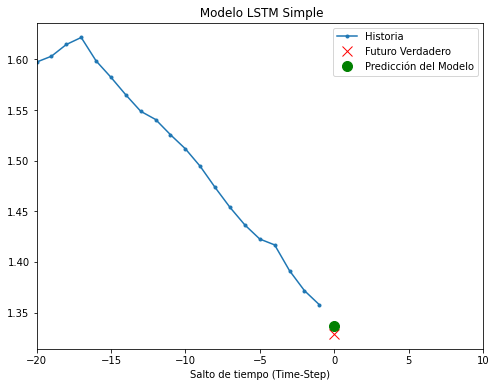

In [42]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, ' Modelo LSTM Simple')
  plot.show()

Esto se ve mejor que la línea de base. Ahora que ha visto los conceptos básicos, pasemos a la segunda parte, donde trabajará con una serie de tiempo multivariante.

## Parte 2: Pronóstico de una serie de tiempo multivariada


El conjunto de datos original contiene catorce variables (features). Para simplificar, esta sección considera solo tres de los catorce originales. Las características utilizadas son la temperatura del aire, la presión atmosférica y la densidad del aire.

Para usar más funciones, agregue sus nombres a esta lista.

In [43]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [44]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00



Echemos un vistazo a cómo cada una de estas características varía con el tiempo.


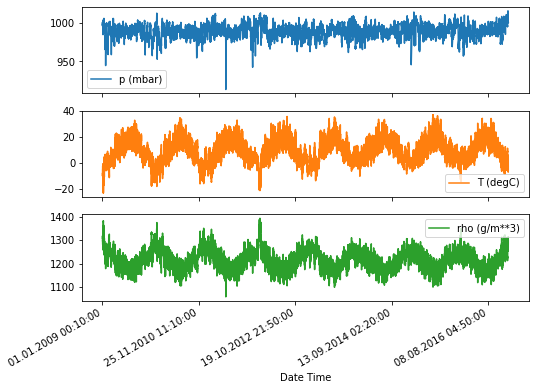

In [45]:
features.plot(subplots=True)
plot.show()

Como se mencionó, el primer paso será estandarizar el conjunto de datos utilizando la media y la desviación estándar de los datos de entrenamiento.

In [46]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [47]:
dataset = (dataset-data_mean)/data_std

## Modelo de un Paso


En una configuración de un  paso, el modelo aprende a predecir un solo punto en el futuro en función del historial proporcionado.

La función a continuación realiza la misma tarea de ventanas que antes, sin embargo, aquí muestra la observación pasada en función del tamaño de paso dado.

In [48]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

En este cuaderno, la red muestra datos de los últimos cinco (5) días, es decir, 720 observaciones que se muestrean cada hora. El muestreo se realiza cada  hora, ya que no se espera un cambio drástico en 60 minutos. Por lo tanto, 120 observaciones representan la historia de los últimos cinco días. Para el modelo de predicción de un solo paso, la etiqueta para un punto de datos es la temperatura dentro de 12 horas. Para crear una etiqueta para esto, se utiliza la temperatura después de 72 (12 * 6) observaciones.

In [49]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [50]:
dataset.shape

(420551, 3)

Veamos una ventana de datos de la historia pasada

In [51]:
print ('Ventana ejemplo de la historia pasada : {}'.format(x_train_single[0].shape))

Ventana ejemplo de la historia pasada : (120, 3)


In [39]:
x_train_single[0:10,:]

array([[[ 0.95547359, -1.99766294,  2.2350791 ],
        [ 0.95304508, -1.95134907,  2.18442875],
        [ 0.96883036, -2.09376424,  2.34176293],
        ...,
        [ 0.9627591 , -2.26396773,  2.52919369],
        [ 1.0186147 , -2.3125973 ,  2.59672749],
        [ 1.06475628, -2.45385463,  2.76164698]],

       [[ 0.96154485, -2.04281897,  2.28524007],
        [ 0.95304508, -1.95134907,  2.18467344],
        [ 0.98218713, -2.09144854,  2.34274168],
        ...,
        [ 0.97854438, -2.27438836,  2.54460901],
        [ 1.02711446, -2.32880716,  2.61654719],
        [ 1.07568454, -2.47701156,  2.78978607]],

       [[ 0.95668784, -2.05439744,  2.29600633],
        [ 0.95304508, -1.98492663,  2.22088721],
        [ 0.9906869 , -2.07176515,  2.32365604],
        ...,
        [ 0.98704414, -2.2778619 ,  2.55097089],
        [ 1.02954297, -2.35312194,  2.64321815],
        [ 1.0793273 , -2.49322142,  2.80813764]],

       ...,

       [[ 0.95304508, -1.95134907,  2.18467344],
        [ 0

In [52]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [53]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

## Compila

Usamos la función de costo mean absolute error definida por

$$
mae = \frac{1}{n}\sum_{i=1}^n|y_i - \tilde{y}_i|
$$

In [54]:
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Revisemos una predicción simple

In [55]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [44]:
single_step_model.predict(x).T

array([[0.31113508, 0.30660605, 0.3011718 , 0.29603294, 0.29335034,
        0.2896034 , 0.28529778, 0.27988672, 0.27210656, 0.26696062,
        0.26408607, 0.26190636, 0.25758702, 0.25107044, 0.24265535,
        0.2377766 , 0.23381363, 0.22916442, 0.22402492, 0.21882279,
        0.2110905 , 0.20560457, 0.20165223, 0.1974039 , 0.19438773,
        0.1901933 , 0.18351775, 0.17847642, 0.1755167 , 0.1725305 ,
        0.17011447, 0.16636392, 0.16177881, 0.15802594, 0.15534782,
        0.15399732, 0.15198213, 0.15149277, 0.14908691, 0.14706229,
        0.14662904, 0.14746   , 0.1462714 , 0.14588462, 0.1447343 ,
        0.14719772, 0.1519379 , 0.15589906, 0.16007721, 0.17051327,
        0.17866726, 0.1856857 , 0.19290064, 0.19431168, 0.20189926,
        0.21648985, 0.22375898, 0.22921431, 0.23576513, 0.24115758,
        0.2501189 , 0.26394078, 0.2715037 , 0.2782664 , 0.28262395,
        0.2870904 , 0.29650158, 0.30599746, 0.31115934, 0.31650588,
        0.31941518, 0.3230543 , 0.33024406, 0.33

## Entrena

In [56]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 41s 207ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 36s 180ms/step - loss: 0.2625 - val_loss: 0.2433
Epoch 3/10
200/200 [==============================] - 35s 174ms/step - loss: 0.2612 - val_loss: 0.2486
Epoch 4/10
200/200 [==============================] - 36s 181ms/step - loss: 0.2568 - val_loss: 0.2460
Epoch 5/10
200/200 [==============================] - 37s 183ms/step - loss: 0.2260 - val_loss: 0.2357
Epoch 6/10
200/200 [==============================] - 38s 188ms/step - loss: 0.2413 - val_loss: 0.2644
Epoch 7/10
200/200 [==============================] - 35s 174ms/step - loss: 0.2410 - val_loss: 0.2522
Epoch 8/10
200/200 [==============================] - 36s 181ms/step - loss: 0.2408 - val_loss: 0.2373
Epoch 9/10
200/200 [==============================] - 36s 180ms/step - loss: 0.2446 - val_loss: 0.2449
Epoch 10/10
200/200 [=========

In [58]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

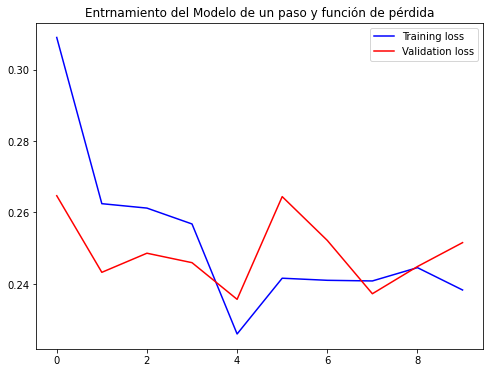

In [59]:
plot_train_history(single_step_history,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Predicciones


Ahora que el modelo está entrenado, hagamos algunas predicciones de muestra. El modelo tiene el historial de tres features en los últimos cinco días muestreados cada hora (120 puntos de datos), ya que el objetivo es predecir la temperatura, el gráfico solo muestra la temperatura pasada. La predicción se hace un día en el futuro (de ahí la brecha entre la historia y la predicción).

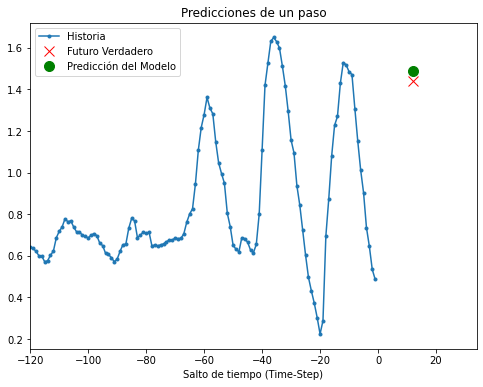

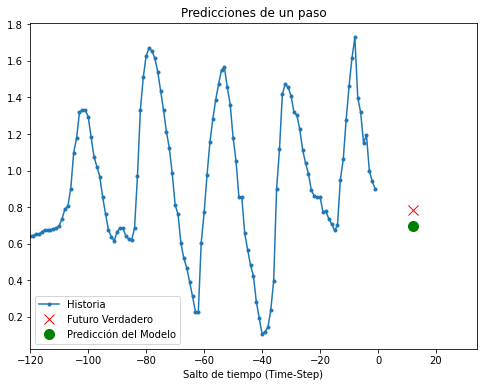

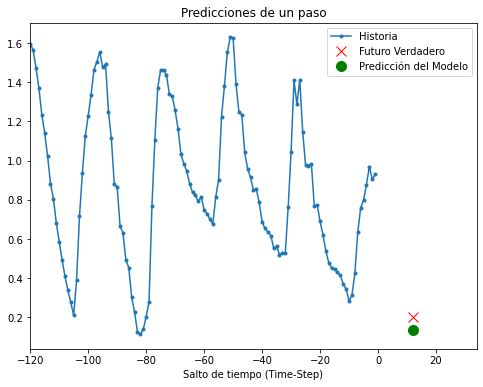

In [60]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
  plot.show()

## Modelo Multipaso

 En un modelo de predicción de varios pasos, dado un historial pasado, el modelo necesita aprender a predecir un rango de valores futuros. Por lo tanto, a diferencia de un modelo de un solo paso, donde solo se predice un único punto futuro, un modelo de varios pasos predice una secuencia del futuro.

Para el modelo de varios pasos, los datos de entrenamiento nuevamente consisten en grabaciones de los últimos cinco días muestreados cada hora. Sin embargo, aquí, el modelo necesita aprender a predecir la temperatura durante las próximas 12 horas. Como se toma una observación cada 10 minutos, el resultado es 72 predicciones. Para esta tarea, el conjunto de datos debe prepararse en consecuencia, por lo tanto, el primer paso es crearlo nuevamente, pero con una ventana de destino diferente.

In [57]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Revisemos una muestra en un punto.

In [61]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [62]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plot de una muestra en un punto.

In [63]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

En este gráfico y otros similares, el historial y los datos futuros se muestrean cada hora.

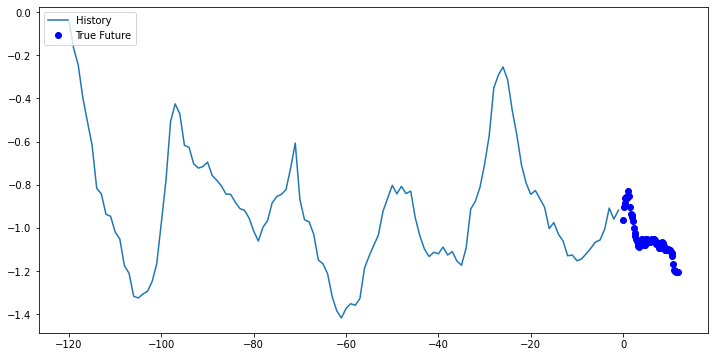

In [53]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

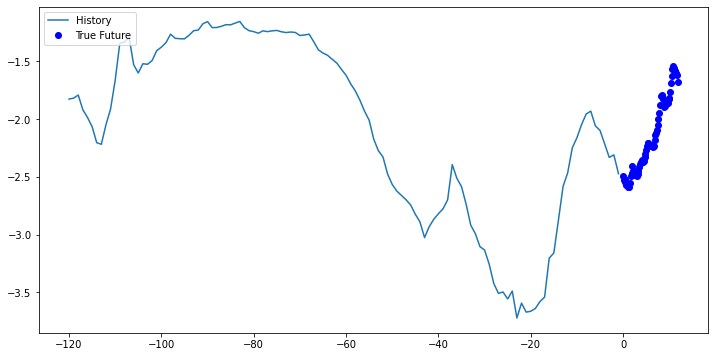

In [65]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Dado que la tarea aquí es un poco más complicada que la tarea anterior, el modelo ahora consta de dos capas LSTM. Finalmente, dado que se hacen 72 predicciones, la capa densa genera 72 predicciones.

### Modelo LSTM

In [66]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [67]:
multi_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


Veamos como predice el modelo antes de entrenarlo.



In [68]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


## Entrena

In [69]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 68s 342ms/step - loss: 94.8263 - val_loss: 0.3164
Epoch 2/10
200/200 [==============================] - 58s 292ms/step - loss: 0.3503 - val_loss: 0.2839
Epoch 3/10
200/200 [==============================] - 58s 292ms/step - loss: 0.4923 - val_loss: 0.2673
Epoch 4/10
200/200 [==============================] - 65s 325ms/step - loss: 0.3043 - val_loss: 0.2271
Epoch 5/10
200/200 [==============================] - 70s 351ms/step - loss: 0.2082 - val_loss: 0.2115
Epoch 6/10
200/200 [==============================] - 73s 364ms/step - loss: 0.2116 - val_loss: 0.2144
Epoch 7/10
200/200 [==============================] - 71s 357ms/step - loss: 0.2039 - val_loss: 0.2011
Epoch 8/10
200/200 [==============================] - 75s 374ms/step - loss: 0.1989 - val_loss: 0.2063
Epoch 9/10
200/200 [==============================] - 71s 355ms/step - loss: 0.2014 - val_loss: 0.1960
Epoch 10/10
200/200 [========

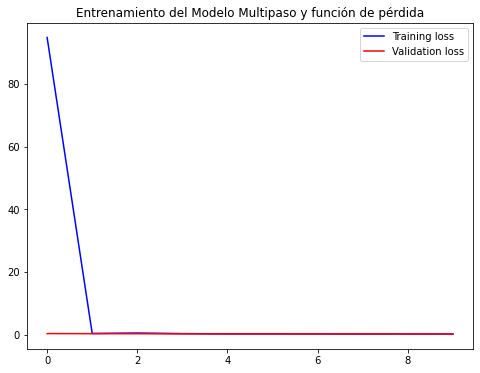

In [70]:
plot_train_history(multi_step_history, 'Entrenamiento del Modelo Multipaso y función de pérdida')

## Predicciones


Veamos ahora qué tan bien la red ha aprendido a predecir el futuro.

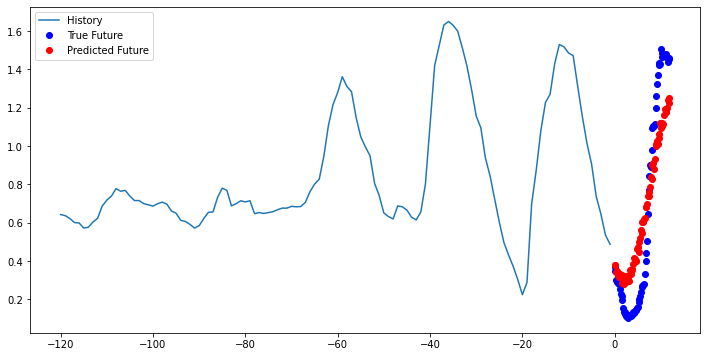

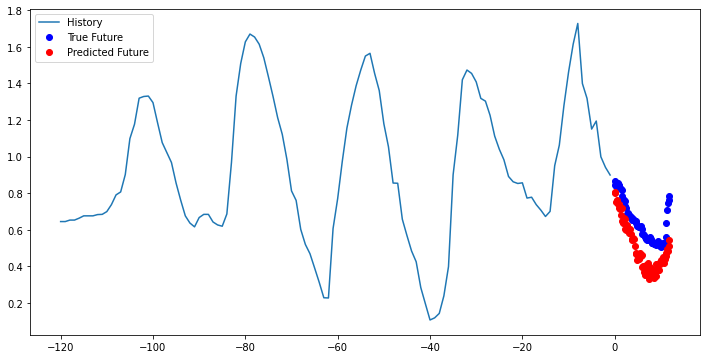

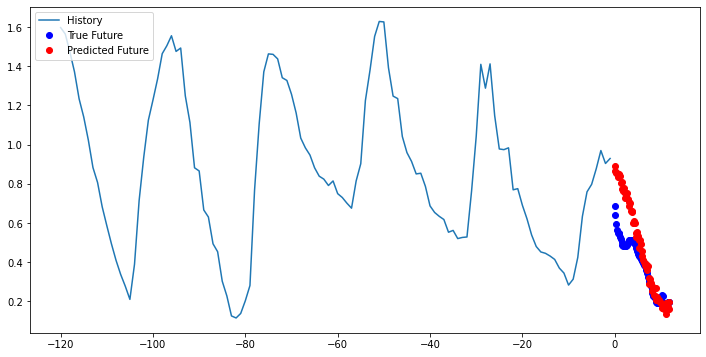

In [71]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Los siguientes pasos


Este cuaderno fue una introducción rápida a la predicción de series de tiempo utilizando un RNR. Ahora puede intentar predecir el mercado de valores y convertirse en multimillonario.

Además, también puede escribir un generador para generar datos (en lugar de la función uni / multivariate_data), que sería más eficiente en la memoria. También puede ver [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing). Úselo para mejorar el código de este cuaderno.